In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd

In [2]:
train_dir = Path("../data1/split/Indian-monuments/images/train")
train_filepaths = (
    list(train_dir.glob("**/*.jpg"))
    + list(train_dir.glob("*.jpeg"))
    + list(train_dir.glob("*.png"))
)
val_dir = Path("../data1/split/Indian-monuments/images/validation")
val_filepaths = (
    list(val_dir.glob("**/*.jpg"))
    + list(val_dir.glob("*.jpeg"))
    + list(val_dir.glob("*.png"))
)
test_dir = Path("../data1/split/Indian-monuments/images/test")
test_filepaths = (
    list(test_dir.glob("**/*.jpg"))
    + list(test_dir.glob("*.jpeg"))
    + list(test_dir.glob("*.png"))
)

In [3]:
def proc_img(filepath):
    labels = [str(filepath[i]).split("\\")[-2] for i in range(len(filepath))]
    print(labels)
    filepath = pd.Series(filepath, name="Filepath").astype(str)
    labels = pd.Series(labels, name="Label")
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    return df


train_df = proc_img(train_filepaths)
val_df = proc_img(val_filepaths)
test_df = proc_img(test_filepaths)

['Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta Caves', 'Ajanta

In [4]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [5]:
unique_labels = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()
train_df["Label"].nunique()

24

In [6]:
val_df["Label"].nunique()

24

In [7]:
test_df["Label"].nunique()

24

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model

# Define data generators with preprocessing function for MobileNetV2
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False,
)

base_model = MobileNetV2(
    weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3)
)
base_model.trainable = False


# adding custom head

x = base_model.output
x = Dense(128, activation="relu")(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(train_df["Label"].nunique(), activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(train_images, validation_data=val_images, epochs=10, verbose=1)

Found 2488 validated image filenames belonging to 24 classes.
Found 308 validated image filenames belonging to 24 classes.
Found 322 validated image filenames belonging to 24 classes.
Epoch 1/10


C:\Users\CHARVI UPRETI\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 453ms/step - accuracy: 0.4463 - loss: 2.0836 - val_accuracy: 0.8539 - val_loss: 0.5804
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 36s 433ms/step - accuracy: 0.9198 - loss: 0.2999 - val_accuracy: 0.8929 - val_loss: 0.3885
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 47s 582ms/step - accuracy: 0.9657 - loss: 0.1429 - val_accuracy: 0.9123 - val_loss: 0.3478
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 79s 947ms/step - accuracy: 0.9893 - loss: 0.0757 - val_accuracy: 0.9286 - val_loss: 0.3016
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 39s 472ms/step - accuracy: 0.9899 - loss: 0.0399 - val_accuracy: 0.9318 - val_loss: 0.3276
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 35s 416ms/step - accuracy: 0.9924 - loss: 0.0330 - val_accuracy: 0.9156 - val_loss: 0.3882
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 35s 428ms/step - accuracy: 0.9904 - loss: 0.0345 - val_accuracy: 0.9286 - val_loss: 0.3044
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 35s 431ms/step - accuracy: 0.9973 - loss: 0.0125 - val_accuracy: 0.938

In [9]:
train_class_labels = train_images.class_indices
val_class_labels = val_images.class_indices
test_class_labels = test_images.class_indices

if train_class_labels == val_class_labels == test_class_labels:
    print("Class labels obtained from all data generators are the same.")
else:
    print("Class labels obtained from data generators are not the same.")

Class labels obtained from all data generators are the same.


C:\Users\CHARVI UPRETI\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       1.00      1.00      1.00        18
           2       1.00      0.91      0.95        11
           3       1.00      0.91      0.95        11
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00         7
           8       1.00      0.60      0.75         5
           9       0.89      0.94      0.91        17
          10       1.00      0.83      0.91         6
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        22
          14       1.00      1.00      1.00        11
          15       1.00      1.00      1.00         6
          16     

<Figure size 1000x800 with 0 Axes>

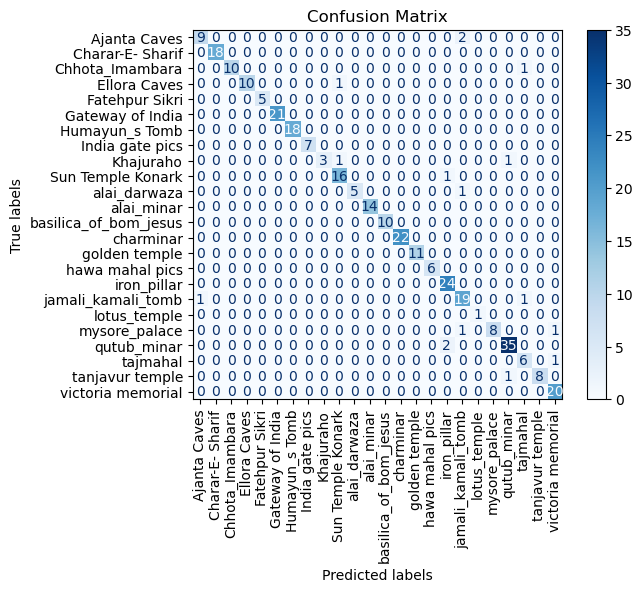

In [10]:
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
)

import seaborn as sns
import matplotlib.pyplot as plt

# Getting predictions
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_images.classes

# Compute evaluation metrics
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

print("Confusion Matrix:")
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)

print("F1 Score:", f1_score(y_true_classes, y_pred_classes, average="weighted"))
print("Recall Score:", recall_score(y_true_classes, y_pred_classes, average="weighted"))
print(
    "Precision Score:",
    precision_score(y_true_classes, y_pred_classes, average="weighted"),
)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get class labels from the data generators
class_labels = train_images.class_indices
class_labels = dict((v, k) for k, v in class_labels.items())
class_labels = [class_labels[i] for i in range(len(class_labels))]

plt.figure(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot(
    cmap="Blues", xticks_rotation="vertical"
)  # Rotate x-axis labels vertically

# Add labels
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

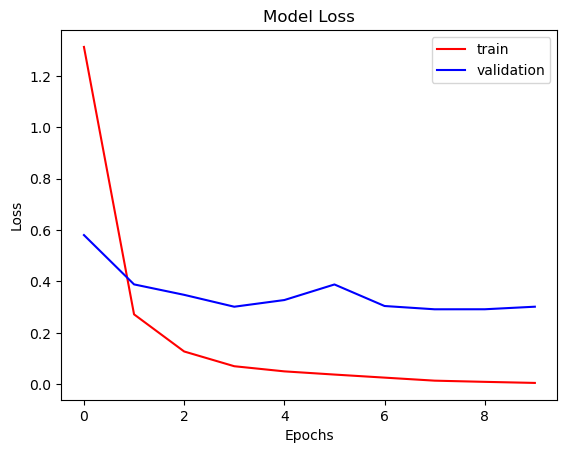

In [11]:
# Plot loss
plt.plot(history.history["loss"], color="red", label="train")
plt.plot(history.history["val_loss"], color="blue", label="validation")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

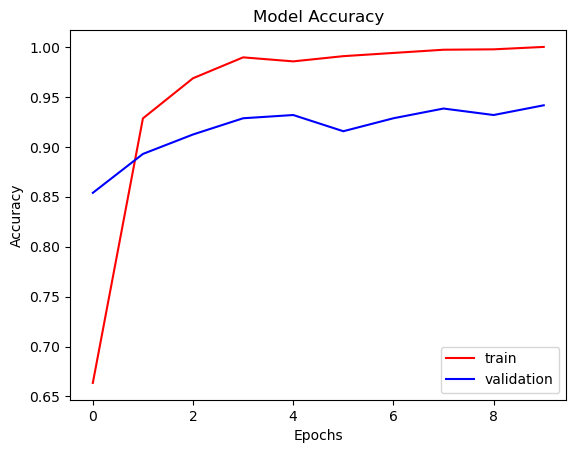

In [12]:
# Plot accuracy
plt.plot(history.history["accuracy"], color="red", label="train")
plt.plot(history.history["val_accuracy"], color="blue", label="validation")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [13]:
predicted_labels = model.predict(test_images)
label_mapping = {v: k for k, v in train_images.class_indices.items()}

# Convert predicted labels to class names
predicted_classes = [label_mapping[np.argmax(label)] for label in predicted_labels]

# Convert true labels to class names
true_classes = [label_mapping[label] for label in test_images.labels]

for i in range(10):
    print(f"True label: {true_classes[i]}, Predicted label: {predicted_classes[i]}")

from sklearn.metrics import accuracy_score

acc = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {100 * acc:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 355ms/step
True label: iron_pillar, Predicted label: iron_pillar
True label: golden temple, Predicted label: golden temple
True label: jamali_kamali_tomb, Predicted label: tajmahal
True label: Ajanta Caves, Predicted label: Ajanta Caves
True label: Fatehpur Sikri, Predicted label: Fatehpur Sikri
True label: Gateway of India, Predicted label: Gateway of India
True label: qutub_minar, Predicted label: qutub_minar
True label: Humayun_s Tomb, Predicted label: Humayun_s Tomb
True label: mysore_palace, Predicted label: mysore_palace
True label: victoria memorial, Predicted label: victoria memorial
Accuracy: 95.03%


In [14]:
# Define the file path to save the predicted classes
output_file = "predicted_classes.txt"

# Write the predicted classes to the file
with open(output_file, "w") as file:
    for predicted_class in predicted_classes:
        file.write(predicted_class + "\n")

print("Predicted classes saved to", output_file)

Predicted classes saved to predicted_classes.txt


In [15]:
model.save(f"model_with_mobilenetv2_{100 * acc:.2f}.h5")

In [16]:
import keras


keras.saving.save_model(model, f"model_with_mobilenetv2_{100 * acc:.2f}.keras")

In [17]:
import pickle

with open("label_mapping.pkl", "wb") as f:
    pickle.dump(label_mapping, f)

print("Label mapping saved successfully.")

Label mapping saved successfully.


In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,808,714 (10.71 MB)

 Trainable params: 183,576 (717.09 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 367,154 (1.40 MB)